NRMSE readout: 0.009201
mean NEMSE W: 0.013561
(2, 1500)
(2, 1500)


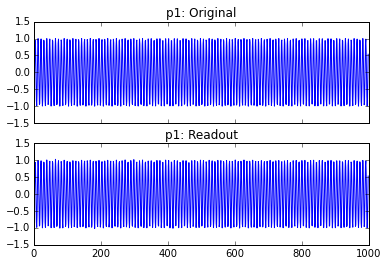

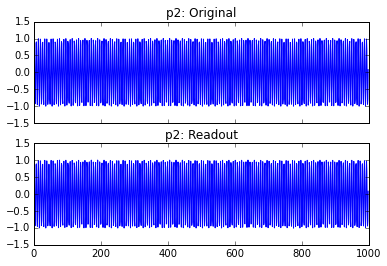

In [2]:
import numpy as np
import scipy.interpolate
import conceptor.util as util
import conceptor.reservoir as reservoir
import conceptor.logic as logic
import matplotlib.pyplot as plt
%matplotlib inline

# Create conceptor network
RNN = reservoir.Reservoir(2, 200)

# Prepare testing data
p1 = np.asarray(range(2000))
p1 = np.sin(2 * np.pi * p1 / np.sqrt(75))
p2 = np.asarray(range(2000))
p2 = np.sin(2 * np.pi * p2 / np.sqrt(40))
ps = np.vstack((p1[None], p2[None]))

p=[]
p.append(ps);


# training
RNN.train(p, 500);


# compute the NRMSE between original and reconstructed signals
def nrmse(output,
          target):
  """
  Compute normalized root mean square error.
    
  @param output: output data in D x time dimension
  @param target: target data in D x time dimension
    
  @return NRMSE: normalized root mean square error. 
  """
    
  if output.ndim == 1 and target.ndim == 1:
    output = output[None].T
    target = target[None].T
    
  combined_var = 0.5 * (np.var(a = target, axis = 1, ddof = 1) + np.var(a = output, axis = 1, ddof = 1))    
  error_signal = (output-target)
    
  return np.mean(np.sqrt(np.mean(error_signal ** 2, 1) / combined_var))

# test readout
print("NRMSE readout: %f" % (nrmse(RNN.W_out.dot(RNN.all_train_args), RNN.all_train_outs)))
total_length = RNN.all_train_args.shape[1]
W_targets = np.arctanh(RNN.all_train_args) - np.matlib.repmat(RNN.W_bias, 1, total_length)
print("mean NEMSE W: %f" % nrmse(RNN.W.dot(RNN.all_train_old_args), W_targets))

y = RNN.W_out.dot(RNN.all_train_args)
print(y.shape)
print(RNN.all_train_outs.shape)

f, axarr = plt.subplots(2, sharex = True, sharey = True)
axarr[0].plot(range(1000), p[0][0, 500:1500])
axarr[0].set_title('p1: Original')
axarr[1].plot(range(1000), y[0, 0:1000])
axarr[1].set_title('p1: Readout')


f2, axarr2 = plt.subplots(2, sharex = True, sharey = True)
axarr2[0].plot(range(1000), p[0][1, 500:1500])
axarr2[0].set_title('p2: Original')
axarr2[1].plot(range(1000), y[1, 0:1000])
axarr2[1].set_title('p2: Readout')

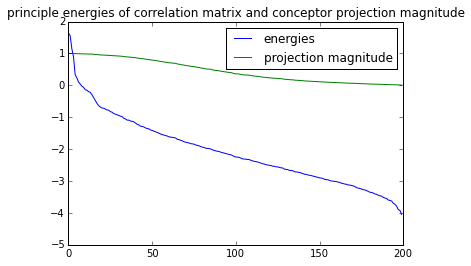

In [3]:
# test conceptors

alphas = [10, 10]
RNN.compute_projectors(alphas)
parameter_nl = 0.1
c_test_length = 200
state_nl = 0.5
W_noisy = RNN.W + parameter_nl * np.abs(RNN.W).dot(np.random.rand(RNN.size_net, RNN.size_net) - 0.5)

x_ctestpl = np.zeros((5, c_test_length, RNN.num_pattern))
p_ctestpl = np.zeros((RNN.size_in, c_test_length, RNN.num_pattern))

for p in range(RNN.num_pattern):
  C = RNN.Cs[0][p]
  x = 0.5 * np.random.rand(RNN.size_net, 1)
  
  for n in range(c_test_length):
    x = np.tanh(W_noisy.dot(x) + RNN.W_bias) + state_nl * (np.random.rand(RNN.size_net, 1) - 0.5)
    x = C.dot(x)
    x_ctestpl[:, n, p] = x[0:5, 0]
    p_ctestpl[:, n, p] = RNN.W_out.dot(x)[:, 0]
    
signal_plot_length = 20
for p in range(RNN.num_pattern):
  int_rate = 20
  this_driver = RNN.pattern_collectors[p][:, 0:signal_plot_length]
  this_out = p_ctestpl[0, :, p]
  this_driver_int_f = scipy.interpolate.interp1d(np.arange(0, signal_plot_length), this_driver, kind = "cubic")
  this_driver_int = this_driver_int_f(np.linspace(0, signal_plot_length - 1, int_rate * signal_plot_length))
  this_out_int_f = scipy.interpolate.interp1d(np.arange(0, c_test_length), this_out, kind="cubic")
  this_out_int = this_out_int_f(np.linspace(0, c_test_length - 1, int_rate * c_test_length))
  
      
plt.figure(2)
plt.title('principle energies of correlation matrix and conceptor projection magnitude')
line1,  = plt.plot(np.log10(RNN.SR_collectors[0]))
line2,  = plt.plot(RNN.Cs[2][0])
plt.legend([line1, (line1, line2)], ["energies", "projection magnitude"])

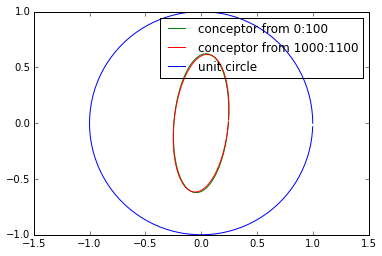

In [4]:
#plot conceptors as 2d ellipses
L = 100

trace1 = RNN.all_train_args[[71, 80], 0:L]
trace2 = RNN.all_train_args[[71, 80], 1000:1000 + L]

R1 = trace1.dot(trace1.T) / L
U1, S1, _ = np.linalg.svd(R1)
R2 = trace2.dot(trace2.T) / L
U2, S2, _ = np.linalg.svd(R2)

cycle_data = np.vstack((np.cos(2 * np.pi * np.arange(0, 200) / 200), np.sin(2 * np.pi * np.arange(0, 200) / 200)))

E1 = R1.dot(cycle_data)
E2 = R2.dot(cycle_data)

a = 1.6
C1 = R1.dot(np.linalg.inv(R1 + a ** -2 * np.eye(2)))
U1c, S1c, _ = np.linalg.svd(C1)
C2 = R2.dot(np.linalg.inv(R2 + a ** -2 * np.eye(2)))
U2c, S2c, _ = np.linalg.svd(C2)
E1c = C1.dot(cycle_data)
E2c = C2.dot(cycle_data);

plt.figure(3)
ucir, = plt.plot(cycle_data[0,:], cycle_data[1,:])
elp1, = plt.plot(E1c[0, :], E1c[1, :])
elp2, = plt.plot(E2c[0, :], E2c[1, :])
plt.legend([elp1, (elp1, elp2), (elp1, ucir)], ["conceptor from 0:100", "conceptor from 1000:1100", "unit circle"])
plt.axis('equal')
plt.show()

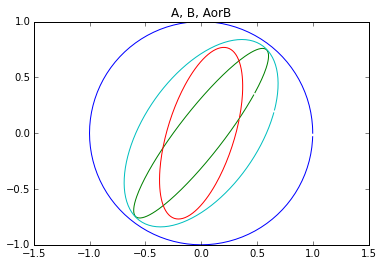

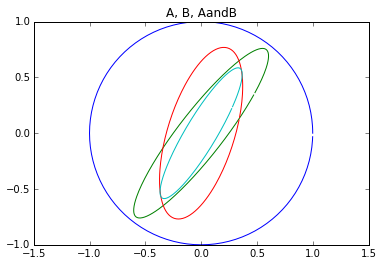

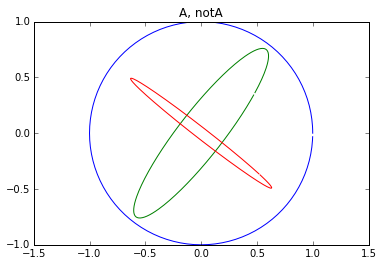

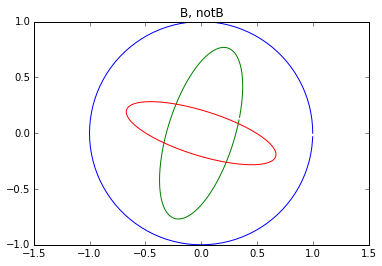

In [5]:
#check OR, AND, NOT using 2D ellipses

dim = 2
newData = 1
I = np.eye(dim)

if newData:
  X = np.random.randn(dim, dim) 
  R = X.dot(X.T) / dim 
  A = R.dot(np.linalg.inv(R + I))
  Ua, Sa, _ = np.linalg.svd(A)
  Sa[0] = 0.95
  Sa[1] = 0.2
  A = Ua.dot(np.diag(Sa)).dot(Ua.T)

  Y = np.random.randn(dim, dim) 
  Q = Y.dot(Y.T) / dim 
  B = Q.dot(np.linalg.inv(Q + I))
  Ub, Sb, _ = np.linalg.svd(B)
  Sb[0] = 0.8
  Sb[1] = 0.3
  B = Ub.dot(np.diag(Sb)).dot(Ub.T)


AandB = logic.AND(A, B)
AorB = logic.OR(A, B)
notA = logic.NOT(A)
notB = logic.NOT(B)

 
# simple plotting 
AE = A.dot(cycle_data)
BE = B.dot(cycle_data)
AorBE = AorB.dot(cycle_data)

plt.figure(4)
plt.plot(cycle_data[0,:], cycle_data[1,:])
plt.plot(AE[0, :], AE[1, :])
plt.plot(BE[0, :], BE[1, :])
plt.plot(AorBE[0, :], AorBE[1, :])
plt.title("A, B, AorB")
plt.axis('equal')
plt.show()

AandBE = AandB.dot(cycle_data)

plt.figure(5)
plt.plot(cycle_data[0,:], cycle_data[1,:])
plt.plot(AE[0, :], AE[1, :])
plt.plot(BE[0, :], BE[1, :])
plt.plot(AandBE[0, :], AandBE[1, :])
plt.title("A, B, AandB")
plt.axis('equal')
plt.show()

notAE = notA.dot(cycle_data)

plt.figure(6)
plt.plot(cycle_data[0,:], cycle_data[1,:])
plt.plot(AE[0, :], AE[1, :])
plt.plot(notAE[0, :], notAE[1, :])
plt.title("A, notA")
plt.axis('equal')
plt.show()

notBE = notB.dot(cycle_data)

plt.figure(7)
plt.plot(cycle_data[0,:], cycle_data[1,:])
plt.plot(BE[0, :], BE[1, :])
plt.plot(notBE[0, :], notBE[1, :])
plt.title("B, notB")
plt.axis('equal')
plt.show()

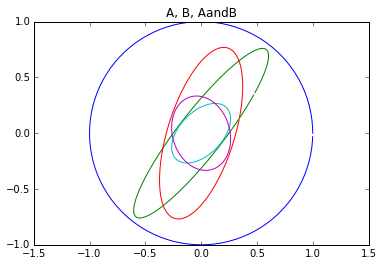

In [8]:
Aonly = logic.AND(A, logic.NOT(AandB))
Bonly = logic.AND(B, logic.NOT(AandB))

AonlyE = Aonly.dot(cycle_data)
BonlyE = Bonly.dot(cycle_data)

plt.figure(5)
plt.plot(cycle_data[0,:], cycle_data[1,:])
plt.plot(AE[0, :], AE[1, :])
plt.plot(BE[0, :], BE[1, :])
plt.plot(AonlyE[0, :], AonlyE[1, :])
plt.plot(BonlyE[0, :], BonlyE[1, :])

plt.title("A, B, AandB")
plt.axis('equal')
plt.show()